<a href="https://colab.research.google.com/github/nanotnam/thesis/blob/main/thesisUNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Jun 28 07:21:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   47C    P0              28W /  72W |   4751MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/thesis_data/train_finall.zip", 'r') as zip_ref:
    zip_ref.extractall('train_set')

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
class BuildingDamageDataset(Dataset):
    def __init__(self, pre_dir, post_dir, seg_pre, seg_post, damage, transform=None):
        self.pre_dir = pre_dir
        self.post_dir = post_dir
        self.seg_pre = seg_pre
        self.seg_post = seg_post
        self.damage = damage
        self.transform = transform
        self.image_ids = [file for file in os.listdir(pre_dir) if file.endswith('.png')]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_id = self.image_ids[idx]

        pre_image = Image.open(os.path.join(self.pre_dir, image_id)).convert('RGB')
        post_image = Image.open(os.path.join(self.post_dir, image_id)).convert('RGB')
        seg_pre_image = Image.open(os.path.join(self.seg_pre, image_id)).convert('L')
        seg_post_image = Image.open(os.path.join(self.seg_post, image_id)).convert('L')
        damage = Image.open(os.path.join(self.damage, image_id)).convert('L')  # Load as grayscale

        if self.transform:
            pre_image = self.transform(pre_image)
            post_image = self.transform(post_image)
        seg_pre_image = self._process_seg_image(seg_pre_image)
        seg_post_image = self._process_seg_image(seg_post_image)
        damage = self._process_gt_image(damage)

        return {'pre_image': pre_image, 'post_image': post_image, 'pre_mask': seg_pre_image, 'post_mask': seg_post_image, 'damage': damage}

    def _process_gt_image(self, gt_image):
        gt_image = np.array(gt_image)
        gt_image = torch.tensor(gt_image, dtype=torch.long)
        gt_image = gt_image - 1
        return gt_image

    def _process_seg_image(self, seg_image):
        seg_image = np.array(seg_image)
        seg_image = torch.tensor(seg_image, dtype=torch.long)
        return seg_image

# Define transformations
data_transforms = transforms.Compose([
  transforms.ToTensor(),
])

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        # nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        # nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv_op(x)

class DownSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    down = self.conv(x)
    p = self.pool(down)

    return down, p

class UpSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    x = torch.cat([x1, x2], 1)
    return self.conv(x)

class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.down_convolution_1 = DownSample(in_channels, 16)
    self.down_convolution_2 = DownSample(16, 32)
    self.down_convolution_3 = DownSample(32, 64)
    self.down_convolution_4 = DownSample(64, 128)

    self.bottle_neck = DoubleConv(128, 256)

    self.up_convolution_1 = UpSample(256, 128)
    self.up_convolution_2 = UpSample(128, 64)
    self.up_convolution_3 = UpSample(64, 32)
    self.up_convolution_4 = UpSample(32, 16)

    self.out = nn.Conv2d(in_channels=16, out_channels=num_classes, kernel_size=1)

  def forward(self, x):
    down_1, p1 = self.down_convolution_1(x)
    down_2, p2 = self.down_convolution_2(p1)
    down_3, p3 = self.down_convolution_3(p2)
    down_4, p4 = self.down_convolution_4(p3)

    b = self.bottle_neck(p4)

    up_1 = self.up_convolution_1(b, down_4)
    up_2 = self.up_convolution_2(up_1, down_3)
    up_3 = self.up_convolution_3(up_2, down_2)
    up_4 = self.up_convolution_4(up_3, down_1)

    out = self.out(up_4)
    return out

In [ ]:
class PrePostUNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.unet = UNet(in_channels, num_classes)
        self.damage_head = nn.Sequential(
            nn.Conv2d(4, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, num_classes, 3, padding=1),
            nn.BatchNorm2d(num_classes),
            nn.ReLU(inplace=True)
        )

    def forward(self, pre_image, post_image):
        out1 = self.unet(pre_image)
        out2 = self.unet(post_image)
        out = self.damage_head(torch.cat((out1, out2), dim=1))
        return out1, out2, out

In [ ]:
# Initialize dataset
train_pre_dir = '/content/train_set/pre'
train_post_dir = '/content/train_set/post'
train_seg_pre = '/content/train_set/seg_pre'
train_seg_post = '/content/train_set/seg_post'
train_damage = '/content/train_set/damage'

In [ ]:
dataset = BuildingDamageDataset(train_pre_dir, train_post_dir, train_seg_pre, train_seg_post, train_damage, transform=data_transforms)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
generator1 = torch.Generator().manual_seed(42)
# Split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=generator1)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


# Define the model (assuming UNet from the previous implementation)
model = PrePostUNet(in_channels=3, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

class_weights = [0.16549766, 0.83450234]

# Convert weights to a tensor
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index = -1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=0.00001)

In [ ]:
num_epochs = 15
train_losses = []
val_losses = []
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for batch_idx, batch in enumerate(train_loader):
    pre_images = batch['pre_image'].to(device)
    post_images = batch['post_image'].to(device)
    seg_pre_images = batch['pre_mask'].to(device).long().squeeze(1)
    seg_post_images = batch['post_mask'].to(device).long().squeeze(1)
    damage = batch['damage'].to(device).long().squeeze(1)  # Convert gt_images to long

    # Forward pass
    out1, out2, out = model(pre_images, post_images)

    # Calculate loss
    loss1 = loss_fn(out1, seg_pre_images)
    loss2 = loss_fn(out2, seg_post_images)
    damage_loss = loss_fn(out, damage)

    loss = loss1 + loss2 + damage_loss

    # if torch.isnan(loss):
    #   print('NaN detected in loss')
    #   break
    running_loss += loss.item()

    optimizer.zero_grad()

    # Backward pass and optimize
    loss.backward()

    optimizer.step()

    # if (batch_idx + 1) % 10 == 0:  # Print progress every 100 batches
    #   print(f'looked at [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item()}')


  epoch_loss = running_loss / len(train_loader)
  print(f'Epoch [{epoch + 1}/{num_epochs}], train Loss: {epoch_loss}')
  train_losses.append(epoch_loss)
  # Validation loop
  model.eval()
  val_running_loss = 0.0
  dam_f1 = 0

  with torch.inference_mode():
    for batch in test_loader:
      val_pre_images = batch['pre_image'].to(device)
      val_post_images = batch['post_image'].to(device)
      val_seg_pre_images = batch['pre_mask'].to(device).long().squeeze(1)
      val_seg_post_images = batch['post_mask'].to(device).long().squeeze(1)
      val_damage = batch['damage'].to(device).long().squeeze(1)  # Convert gt_images to long

      val_out1, val_out2, val_out = model(val_pre_images, val_post_images)
      val_loss1 = loss_fn(val_out1, val_seg_pre_images)
      val_loss2 = loss_fn(val_out2, val_seg_post_images)
      val_damage_loss = loss_fn(val_out, val_damage)

      val_loss = val_loss1 + val_loss2 + val_damage_loss
      val_running_loss += val_loss.item()


      # Calculate the accuracies
      pred_labels_damage = torch.argmax(val_out, dim=1).squeeze().cpu().numpy().flatten()
      truth_labels_damage = val_damage.cpu().numpy().flatten()

      damage_f1 = f1_score(truth_labels_damage[truth_labels_damage != -1], pred_labels_damage[truth_labels_damage != -1], labels = [0, 1], average=None, zero_division = 0)

      dam_f1 += damage_f1
  scheduler.step(val_running_loss)
  avg_val_loss = val_running_loss / len(test_loader)
  val_losses.append(avg_val_loss)
  overall_f1 = dam_f1/len(test_loader)

  print(f'Epoch [{epoch + 1}/{num_epochs}], test Loss: {avg_val_loss}')
  print('\t\tAverage Damage f1 score:')
  for i, f1 in enumerate(overall_f1):
    print(f'\t\t\tClass {i}: {f1}')
  print(f'\t\tMean Damage f1 score: {np.mean(overall_f1)}')


Epoch [1/15], train Loss: 1.3007013984304021
Epoch [1/15], test Loss: 1.0607041251991238
		Average Damage f1 score:
			Class 0: 0.8576329169479966
			Class 1: 0.412200217150279
		Mean Damage f1 score: 0.6349165670491378
Epoch [2/15], train Loss: 1.0555107232586491
Epoch [2/15], test Loss: 1.0017194603699433
		Average Damage f1 score:
			Class 0: 0.8376506549168181
			Class 1: 0.44518602024348114
		Mean Damage f1 score: 0.6414183375801497
Epoch [3/15], train Loss: 0.9624402086866375
Epoch [3/15], test Loss: 0.9172622874793965
		Average Damage f1 score:
			Class 0: 0.9150761270061308
			Class 1: 0.5146613570789966
		Mean Damage f1 score: 0.7148687420425637
Epoch [4/15], train Loss: 0.8779716468061792
Epoch [4/15], test Loss: 0.8135295539009495
		Average Damage f1 score:
			Class 0: 0.8923891085581592
			Class 1: 0.5351955590454752
		Mean Damage f1 score: 0.7137923338018173
Epoch [5/15], train Loss: 0.8109364303633458
Epoch [5/15], test Loss: 0.7993056329976312
		Average Damage f1 score:


In [ ]:
from pathlib import Path

# Setup
data_path = Path("/content/drive/MyDrive/thesis_data")
model_path = data_path / "models"

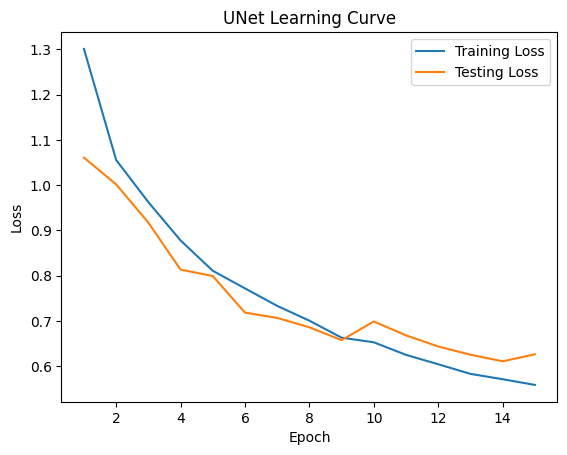

In [ ]:
# Plot the learning curve
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('UNet Learning Curve')
plt.legend()

# Save the plot as an image file
plot_name = "UNET_loss.png"
plot_save_path = model_path / plot_name
plt.savefig(plot_save_path)

In [ ]:
model_name = 'UNET_model.pth'
model_save_path = model_path / model_name
torch.save(model.state_dict(), model_save_path)